In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


In [6]:
# ======== Imports =========
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
# import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

# Predicting Road Accident Risk

In [7]:
train_df = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")

train = train_df.copy()
test = test_df.copy()

print("Train shape: ", train.shape, "\n")
# Data info
print("Data info:", train.info(), "\n")
train.head()

Train shape:  (517754, 14) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  floa

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [8]:
# Check for NaNs
print("Train Null values:", train.isna().any().sum())
print("Test Null values:", test.isna().any().sum())

Train Null values: 0
Test Null values: 0


In [9]:
test.shape

(172585, 13)

In [10]:
# Features & Target split
target = "accident_risk"
id_col = "id"

X = train.drop([target, id_col], axis=1)
y = train[target]

In [11]:
# Identify feature types
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
boolean_features = X.select_dtypes(include=['bool']).columns.tolist()

# Remove accidental numeric bools
numeric_features = [col for col in numeric_features if col not in boolean_features]

print("Numeric cols:", numeric_features,"\n")
print("Categorical cols:", categorical_features,"\n")
print("Boolean cols:", boolean_features,"\n")
features = numeric_features + categorical_features + boolean_features

Numeric cols: ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents'] 

Categorical cols: ['road_type', 'lighting', 'weather', 'time_of_day'] 

Boolean cols: ['road_signs_present', 'public_road', 'holiday', 'school_season'] 



## Univariate Analysis

### Target Feature

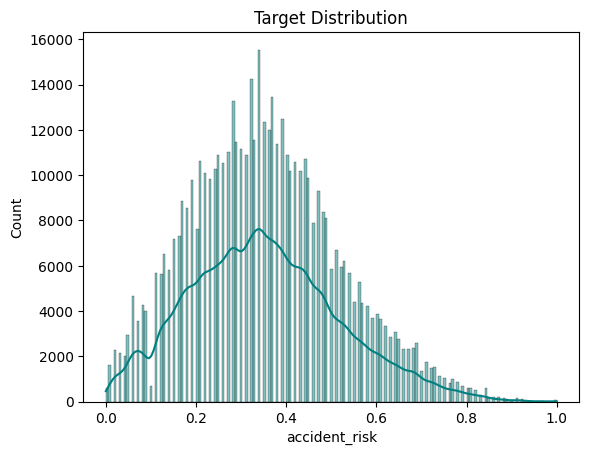

In [12]:
# Target Distribution
sns.histplot(y, color='teal', kde=True)
plt.title('Target Distribution')
plt.show()

Target skewness: 0.37841797634228086


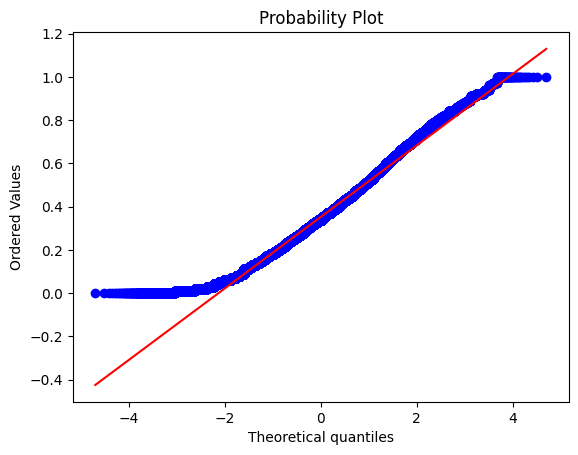

In [13]:
import scipy.stats as stats

print("Target skewness:", y.skew())

stats.probplot(train[target], dist="norm", plot=plt)
plt.show()

Target values are fairly symmetrical with a skew value of `0.378`. We won't be doing any transformations to `normalize` further.

### Numeric Features

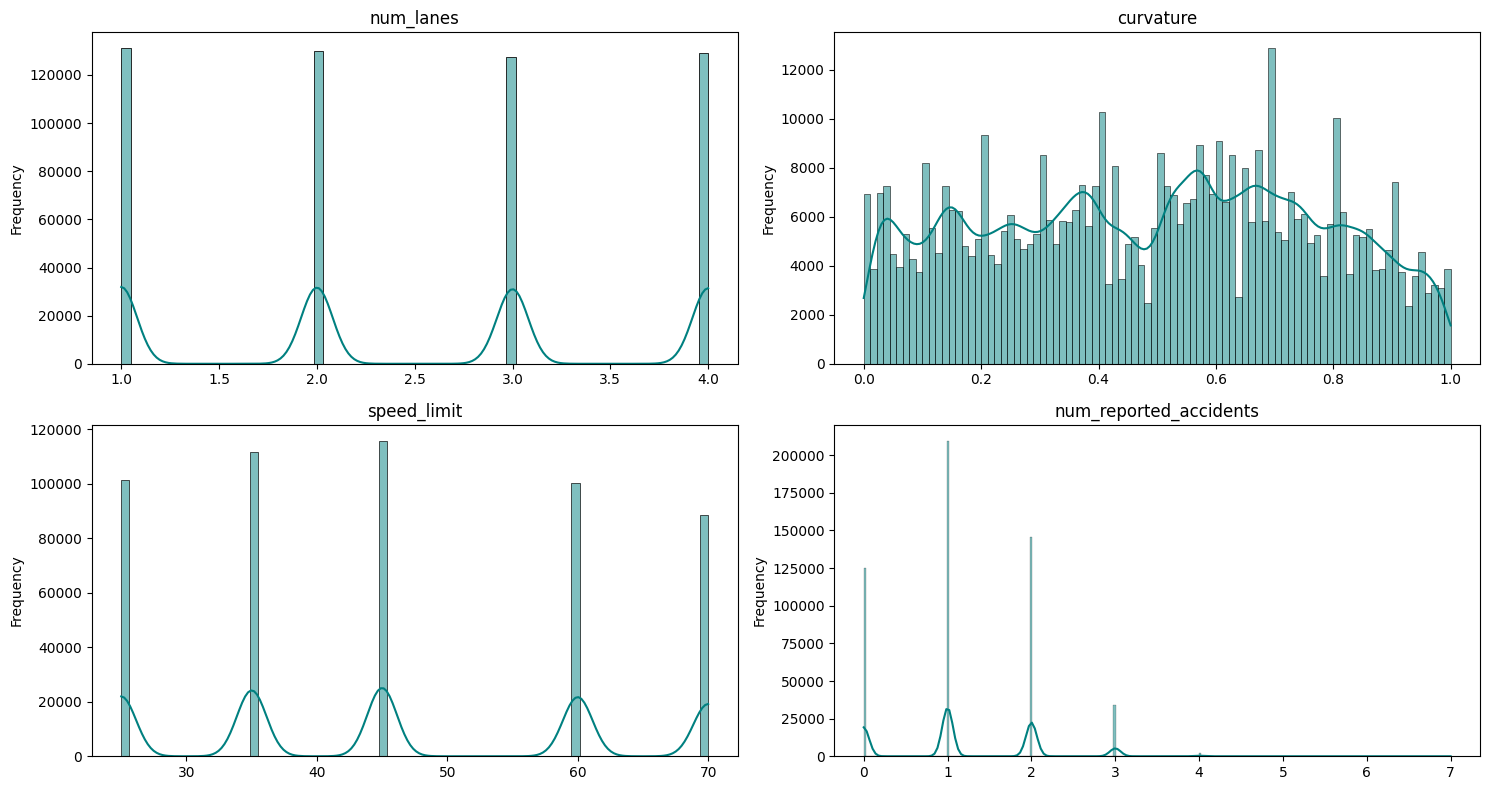

In [14]:
# Numeric features distribution
num_cols = numeric_features

# Grid setup
n_cols = 2
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
axes = axes.flatten()  # flatten for easy iteration

# Plot histograms
for i, col in enumerate(num_cols):
    sns.histplot(train[col], ax=axes[i], color='teal', kde=True)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Categorical & Boolean Features Distribution

In [15]:
def plot_categorical_and_boolean_distributions(df, cat_cols, bool_cols):
    # Combine lists but keep track of what’s what
    all_cols = cat_cols + bool_cols
    n_cols = 3  # number of subplots per row
    n_rows = int(np.ceil(len(all_cols) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(all_cols):
        ax = axes[i]
        if col in cat_cols:
            # Plot for categorical columns
            sns.countplot(x=col, data=df, ax=ax, palette='crest', order=df[col].value_counts().index)
            ax.set_title(f'Distribution of {col}')
            ax.set_xlabel('')
            ax.set_ylabel('Count')
            ax.tick_params(axis='x', rotation=45)
        elif col in bool_cols:
            # Plot for boolean columns
            sns.countplot(x=col, data=df, ax=ax, palette='crest')
            ax.set_title(f'Distribution of {col}')
            ax.set_xlabel('')
            ax.set_ylabel('Count')
            ax.set_xticklabels(['False', 'True'])  # optional, if dtype is boolean
        else:
            ax.set_visible(False)

    # Hide unused subplots (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

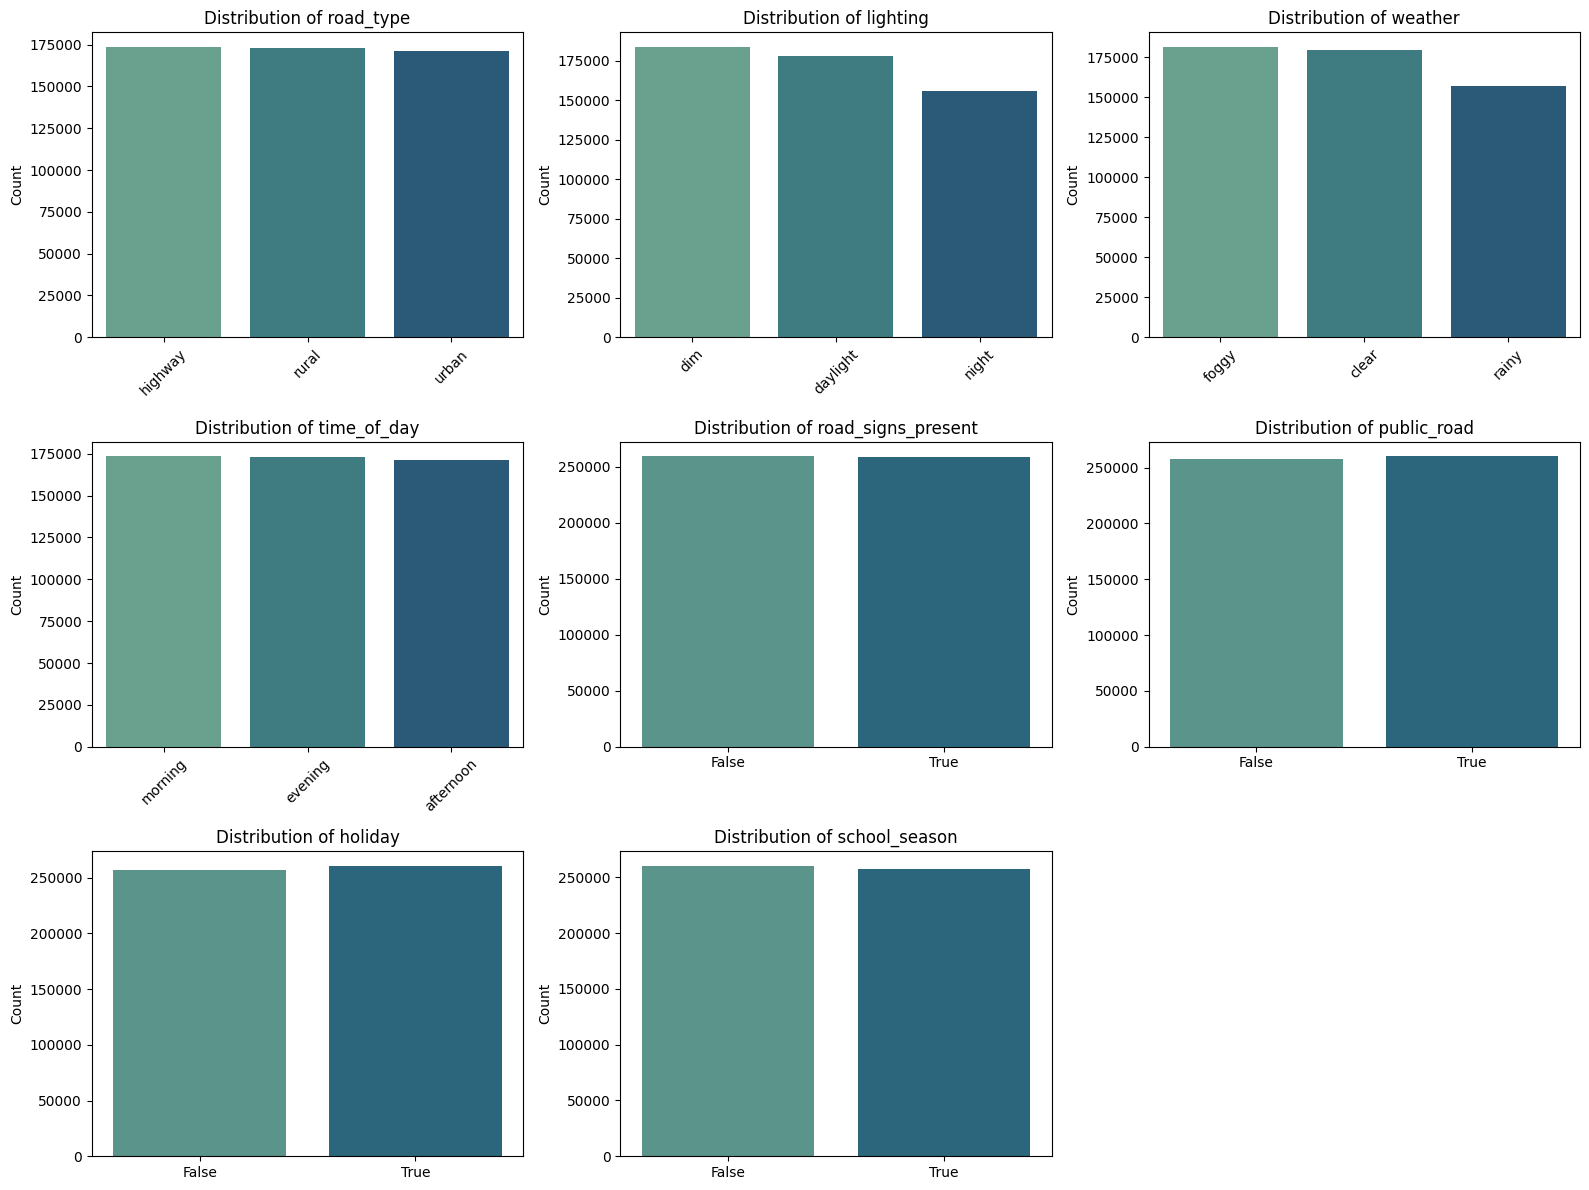

In [16]:
# Plot features
cat_cols = categorical_features
bool_cols = boolean_features
plot_categorical_and_boolean_distributions(train, cat_cols, bool_cols)

The classes in feature columns seem to be fairly distributed across all categories; no particular class dominates a feature. 

## Bivariate Analysis

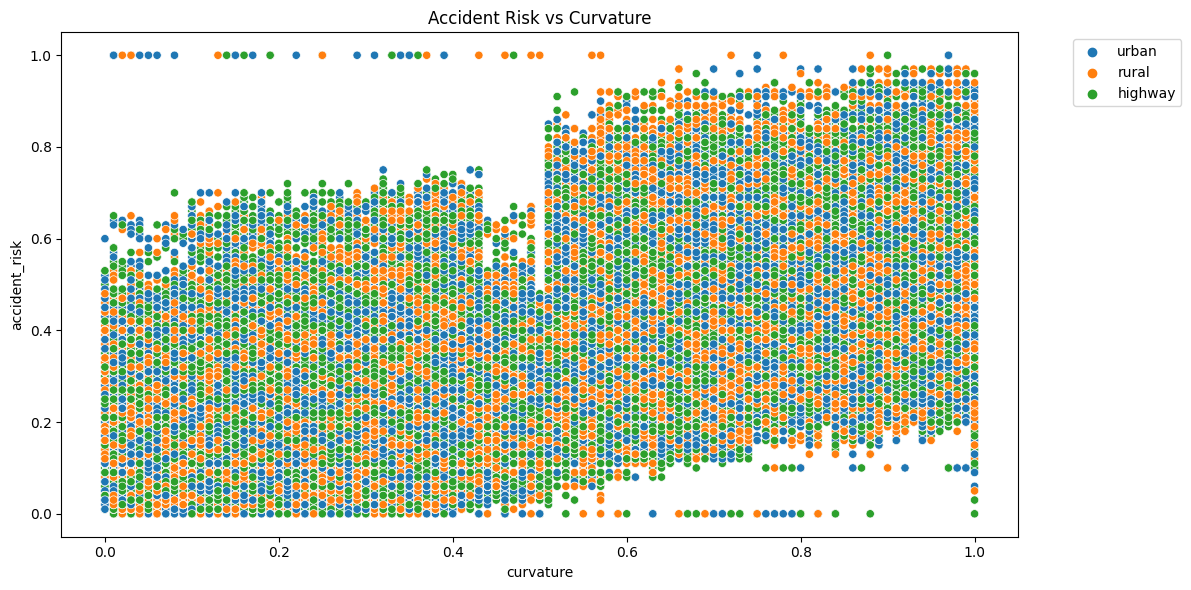

In [17]:
# Basic scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=train, 
    x="curvature", 
    y=y,
    hue='road_type'
)
plt.title("Accident Risk vs Curvature")

# Push legend outside (right side)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

There's a positive correlation between `curvature` and `accident_risk`. Roads with higher curvature tend to have a higher accident risk compared to those with less curvature. There are a few cases where roads with little curvature have very high accident risk and some cases with high curvature (mostly urban type roads) and very low accident risk. These are our outliers. 

In [18]:
road_type_risk = train.groupby('road_type')['accident_risk'].mean().round(2)
road_type_risk

road_type
highway    0.35
rural      0.35
urban      0.36
Name: accident_risk, dtype: float64

Accident risk is moderate across all road types but urban roads have slightly higher accident risk compared to the other road types

In [19]:
weather_risk = train.groupby('weather')['accident_risk'].mean().round(3)
weather_risk

weather
clear    0.310
foggy    0.386
rainy    0.361
Name: accident_risk, dtype: float64

Foggy conditions are associated with the higher accident risk followed by rainy weather conditions. Clear weather ranks the lowest in accident risk. 

In [20]:
public_risk = train.groupby('public_road')['accident_risk'].mean().round(3)
public_risk

public_road
False    0.347
True     0.358
Name: accident_risk, dtype: float64

In [21]:
time_of_day_risk = train.groupby('time_of_day')['accident_risk'].mean().round(3)
time_of_day_risk

time_of_day
afternoon    0.351
evening      0.355
morning      0.351
Name: accident_risk, dtype: float64

## Multi-variate Analysis

In [22]:
# Correlation with Target
corr = train.drop(columns='id').corr(numeric_only=True)
print('Correlation with Target \n', corr['accident_risk'].sort_values(ascending=False))

Correlation with Target 
 accident_risk             1.000000
curvature                 0.543946
speed_limit               0.430898
num_reported_accidents    0.213891
holiday                   0.051129
public_road               0.031032
road_signs_present        0.000629
school_season            -0.000977
num_lanes                -0.006003
Name: accident_risk, dtype: float64


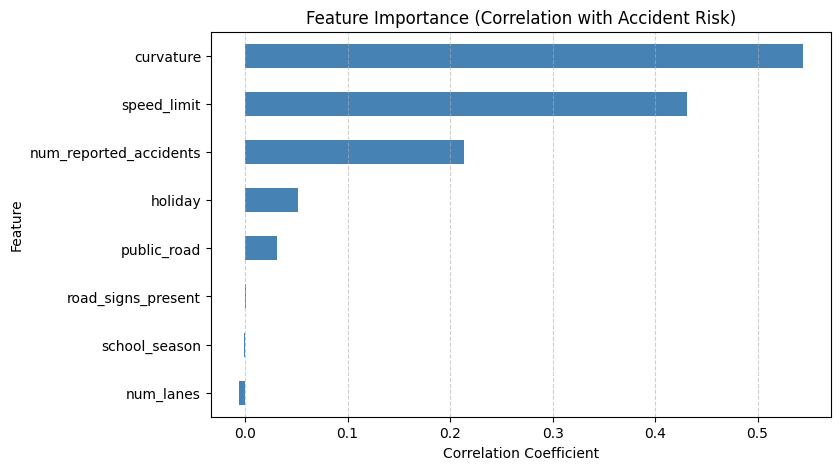

In [23]:
# corr.plot(kind="barh", figsize=(6,5), title="Correlation Between Features and Target")
# plt.gca().invert_yaxis()
# plt.show()

corr_with_target = corr['accident_risk'].drop('accident_risk').sort_values(ascending=False)

plt.figure(figsize=(8, 5))
corr_with_target.plot(kind='barh', color='steelblue')
plt.title('Feature Importance (Correlation with Accident Risk)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


To get an initial sense of which features most influence accident risk, I computed the **Pearson correlation coefficients** between each feature and the target variable accident_risk.

The results show that:

* **Curvature and Speed Limit** have the strongest positive correlations with accident risk, implying sharper turns and higher speeds are major contributors to risk.

* **Number of Reported Accidents** also shows a moderate correlation, suggesting historical accident density is a meaningful indicator.

* **Holiday**, **Public Road**, and **Road Signs Present** have weak positive correlations — their effect might be situational or interact with other factors.

* **School Season** and **Number of Lanes** appear almost uncorrelated with accident risk, hinting they may not provide much predictive value individually.

This correlation-based ranking offers a baseline “importance view” before fitting any models. In later steps, model-based feature importances (e.g., from Random Forest or LightGBM) will provide a more nuanced picture by capturing nonlinear and interaction effects.

Multicollinearity Check 

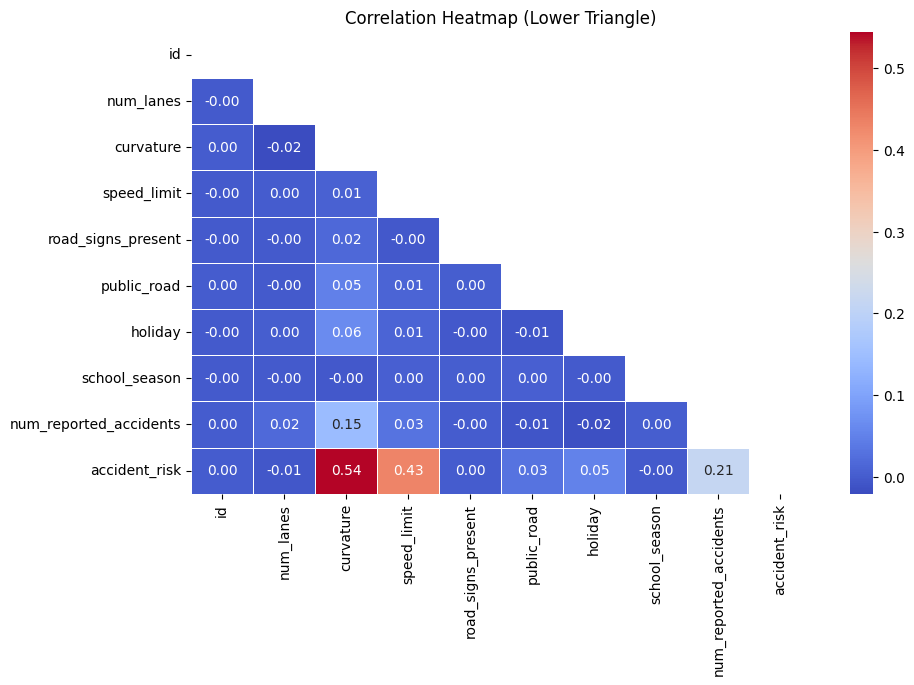

In [24]:
# Plot heatmap

# Compute correlation matrix
corr_matrix = train.corr(numeric_only=True)

plt.figure(figsize=(10, 6))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap (Lower Triangle)")
plt.show()

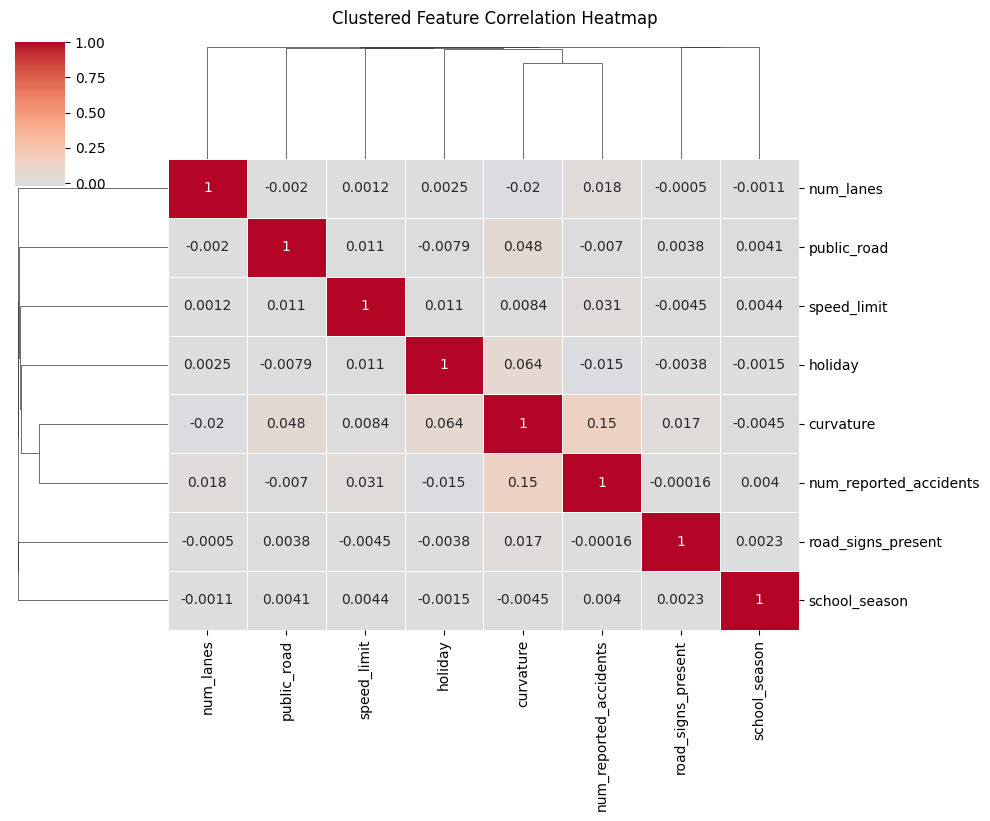

In [25]:
# Clustered heatmap
# sns.clustermap(
#     corr_matrix,
#     annot=True,         # show correlation values
#     fmt=".2f",          # two decimal places
#     cmap='coolwarm',    # diverging color scheme
#     center=0,           # center at zero correlation
#     linewidths=0.5,     # gridlines
#     figsize=(10, 8)
# )

# plt.suptitle("Clustered Feature Correlation Heatmap", y=1.02)
# plt.show()

corr = X.corr(numeric_only=True)
sns.clustermap(
    corr, 
    cmap='coolwarm', 
    annot=True,
    center=0,
    linewidth=0.5,
    figsize=(10,8)
)
plt.suptitle("Clustered Feature Correlation Heatmap", y=1.02)
plt.show()

### Feature Relationship Analysis (Clustermap Insights)

We used a **correlation clustermap** to explore relationships among the predictor variables.

Interestingly, the clustermap shows **no strong or well-defined clusters** between features.  
This indicates that:

- **Most features are independent** — they don’t move together strongly.  
- **No dominant multicollinearity** is present, meaning we’re unlikely to face redundant predictors.  
- Each variable likely captures a **distinct aspect** of the accident risk phenomenon:
  - Road characteristics (`curvature`, `speed_limit`, `num_lanes`)
  - Environmental conditions (`weather`, `lighting`, `time_of_day`)
  - Contextual factors (`holiday`, `school_season`, `public_road`, `road_signs_present`)

This is a *good sign* for modeling:  
our dataset provides a **diverse and non-overlapping** set of predictors, improving the model’s ability to learn from multiple independent signals rather than repeated ones.

> In short — the clustermap confirms that each feature contributes a different “dimension” to the accident risk story, with minimal redundancy.


## Modeling 

In [26]:
# ========== Train-Test Split ==========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [27]:
# Preprocessing Pipeline (Non-CatBoost Models)
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

boolean_transformer = "passthrough"  # since already True/False

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("bool", boolean_transformer, boolean_features)
    ]
)

### Baseline Models

In [28]:
#  Baseline Models (Sklearn)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=100, random_state=42, n_jobs=-1
    ),
    "SVR": LinearSVR(),
    "LightGBM": LGBMRegressor(),
    "XGBoost": XGBRegressor(),
    "CatBoost": CatBoostRegressor(verbose=0, thread_count=-1)
}

In [29]:
# # Training & Evaluation Function
results = []
fitted_models = {}

for name, model in models.items():
    print(f"\n===== {name} =====")
    
    if name == "CatBoost":
        # CatBoost handles categories directly
        X_cb = X.copy()
        # cat_features =  X_cb.select_dtypes(include="object").columns.tolist()
        cat_features = categorical_features
        
        model.fit(X_train, y_train, cat_features=cat_features)
        preds = model.predict(X_test)
    else:
        # All other models use preprocessing pipeline
        pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", model)
        ])
        pipeline.fit(X_train, y_train)
        preds = pipeline.predict(X_test)
        fitted_models[name] = pipeline

    rmse = mean_squared_error(y_test, preds, squared=False)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2})
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")


===== Linear Regression =====
RMSE: 0.0735 | MAE: 0.0583 | R²: 0.8042

===== Random Forest =====
RMSE: 0.0594 | MAE: 0.0461 | R²: 0.8722

===== SVR =====
RMSE: 0.0739 | MAE: 0.0585 | R²: 0.8024

===== LightGBM =====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 20
[LightGBM] [Info] Start training from score 0.352605
RMSE: 0.0563 | MAE: 0.0437 | R²: 0.8850

===== XGBoost =====
RMSE: 0.0563 | MAE: 0.0437 | R²: 0.8853

===== CatBoost =====
RMSE: 0.0563 | MAE: 0.0437 | R²: 0.8854


In [30]:
results_df = pd.DataFrame(results).sort_values("RMSE")
display(results_df)

,Model,RMSE,MAE,R2
5,CatBoost,0.056258,0.043694,0.885378
4,XGBoost,0.056269,0.043675,0.885333
3,LightGBM,0.056342,0.043745,0.885035
1,Random Forest,0.059408,0.046098,0.872181
0,Linear Regression,0.073530,0.058312,0.804192
2,SVR,0.073858,0.058538,0.802445


### Model Training & Evaluation Insights

After training multiple models with consistent preprocessing and evaluation metrics, the results show a clear performance hierarchy:

- **CatBoost**, **XGBoost**, and **LightGBM** form the leading trio — all achieving an R² ≈ 0.885 and RMSE around 0.056.  
  - These models handle **nonlinear relationships and categorical encoding** very effectively.
  - CatBoost edges slightly ahead, likely due to its **native handling of categorical variables** and **robust regularization**.
- **Random Forest** performs well but slightly below the gradient boosting models, suggesting that **boosting improves fine-grained fit** on complex patterns.
- **Linear Regression** and **SVR** show notably lower R² (~0.80), indicating that **the relationship between features and target is nonlinear** and not well captured by purely linear models.

### Key Takeaways
- Tree-based gradient boosting models clearly outperform linear and kernel-based approaches.  
- CatBoost may be the best **default model** moving forward, especially when interpretability and categorical handling are critical.  
- The performance gap between boosting variants (CatBoost, XGBoost, LightGBM) is minimal — a good sign of model stability and consistent preprocessing.

*What's next*:

1. **Feature Importance Analysis**
→ Visualize and compare feature importances across CatBoost, XGBoost, and LightGBM.

1. **Cross-Validation Evaluation**
→ Confirm if results are stable across folds (RMSE and R² consistency).

1. **Residual Analysis**
→ Plot residuals vs predictions to check bias or underfitting in specific regions.

1. **Model Ensemble**
→ Try averaging predictions from CatBoost + LightGBM + XGBoost to possibly squeeze an extra 0.001–0.002 improvement in RMSE.

### Feature Importance Analysis

We'll extract feature importances from tree-based models only as linear models don't provide meaningful importance in this context.

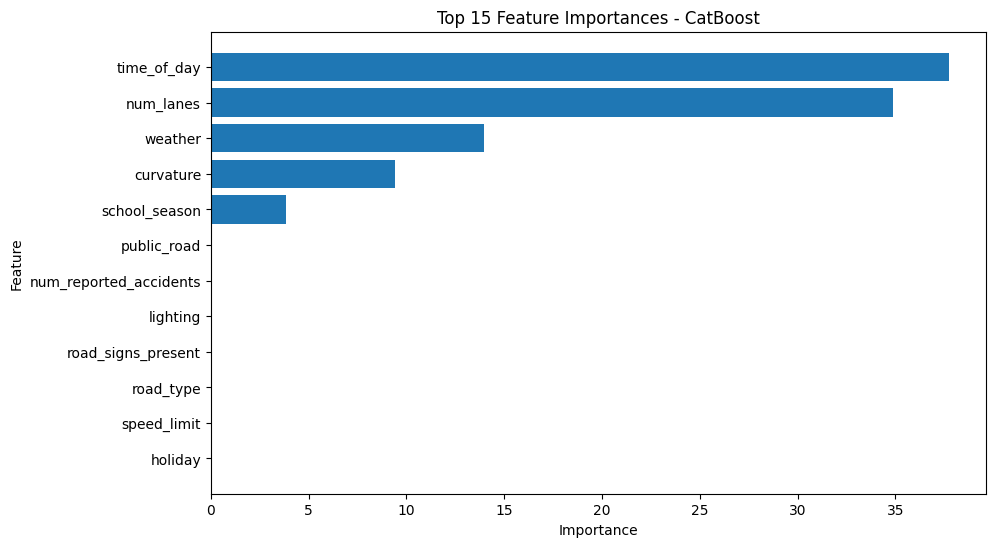

In [31]:
def plot_feature_importance(model, model_name, feature_names):
    """Plots feature importance for tree-based models."""
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        # CatBoost case (fitted directly)
        importances = model.get_feature_importance()
    
    fi_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(fi_df["Feature"][:15][::-1], fi_df["Importance"][:15][::-1])
    plt.title(f"Top 15 Feature Importances - {model_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

    return fi_df

# Using CatBoost’s version since it performed best
cat_features_full = categorical_features + numeric_features + boolean_features
cat_importance_df = plot_feature_importance(models["CatBoost"], "CatBoost", cat_features_full)

In [32]:
cat_importance_df

,Feature,Importance
3,time_of_day,37.730449
4,num_lanes,34.859523
2,weather,13.958418
5,curvature,9.404293
11,school_season,3.857006
9,public_road,0.051072
7,num_reported_accidents,0.039588
1,lighting,0.039551
8,road_signs_present,0.018084
0,road_type,0.018053


### Feature Importance Insights (CatBoost Model)

The CatBoost model reveals clear priorities in how different features contribute to predicting **accident risk**.

* Accident risk follows strong daily patterns — likely reflecting traffic density, driver alertness, and visibility differences between day and night.
* Multi-lane roads may carry heavier, faster traffic, increasing both accident likelihood and severity.
* Conditions such as rain, fog, or glare affect visibility and road friction — direct contributors to risk.
* Curvier roads are harder to navigate safely, especially at higher speeds or in poor weather. 
* Accident probability increases during school sessions due to increased pedestrian and bus traffic near schools. 
* Features like `lighting`, `road_type`, and `speed_limit` have minimal individual influence, possibly because their effects are already captured by stronger features (e.g., `time_of_day` or `num_lanes`).


*Interpretation Summary*:

The model heavily depends on **temporal** and **road-structure** factors:
- `time_of_day` dominates, suggesting accident risk is highly time-dependent.
- `num_lanes` and `curvature` show that **road geometry** plays a major role.
- Weather and contextual signals like `school_season` add subtle but meaningful effects.

Together, these suggest that **accident risk is not random** — it’s systematically tied to when and where vehicles operate.


*Next Analytical Steps*
- **Partial Dependence / SHAP Analysis** — to understand *how* top features influence risk.
- **Interaction Checks** — e.g., how `curvature` and `weather` interact.
- **Residual Diagnostics** — to detect patterns or systematic model errors across time or road types.

> In essence, the CatBoost model identifies strong *temporal* and *structural* signals as the backbone of road accident risk.


### Predicted Values vs Actual Values

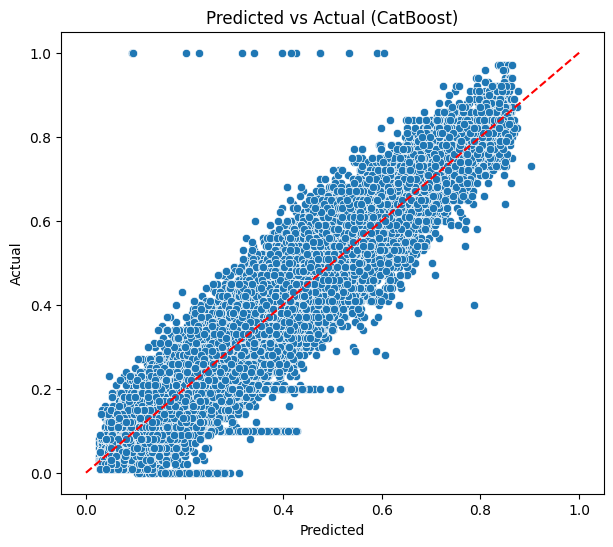

In [33]:
# Predict on test data
y_pred_cb = models["CatBoost"].predict(X_test)

# Compute residuals
residuals = y_test - y_pred_cb

# Scatter: Predicted vs Actual
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_pred_cb, y=y_test)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Predicted vs Actual (CatBoost)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

- The points align closely along the **45° reference line**, indicating strong agreement between predicted and actual accident risk values.  
- Slight scatter at higher predicted values suggests **small deviations in extreme-risk cases**, which is typical when such cases are underrepresented in the data.  
- The overall trend confirms that the model maintains **good calibration** across the risk spectrum — neither systematically over- nor underpredicting.

### Residual Distribution

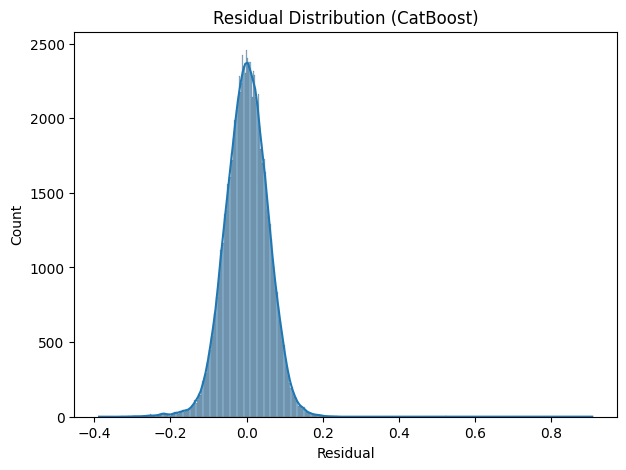

In [34]:
# Residual distribution
plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (CatBoost)")
plt.xlabel("Residual")
plt.show()

- The residuals form a roughly **symmetric, bell-shaped curve centered near zero**, implying that errors are normally distributed *(errors are mostly random)*  
- The absence of heavy skew or long tails indicates **no major bias** in predictions.  
- A tight concentration of residuals around zero further supports the model’s stability and accuracy.

### Residual vs Predicted

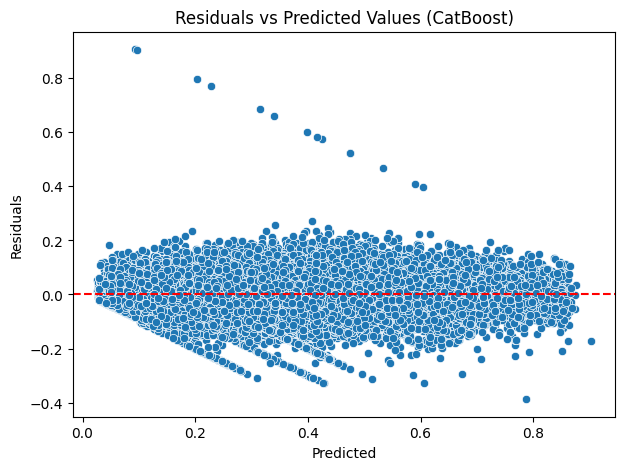

In [35]:
# Residuals vs Predicted
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_cb, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values (CatBoost)")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

- Residuals are randomly scattered around zero without any clear pattern — evidence of **homoscedasticity**, meaning the model’s error variance is stable across different prediction levels.  
- No visible curvature or funnel shape → the model isn’t systematically worse for low or high predictions.  
- Occasional outliers likely represent **rare or atypical conditions** (e.g., unusual weather or time combinations).

### Interpretation Summary
- The diagnostic visuals confirm that **CatBoost generalizes well** and captures most of the meaningful structure in the data.  
- Residuals behave as expected for a strong, well-calibrated model.  
- Minor dispersion at the extremes suggests the next optimization focus could be:
  - enriching high-risk examples through **targeted sampling or feature interactions**, or  
  - tuning model depth/learning rate to reduce edge-case variance.

> Overall, the residual analysis confirms that our model predictions are unbiased, stable, and well-aligned with observed accident risk patterns.

### Baseline Modeling Conclusion

Our baseline modeling phase successfully established a solid predictive foundation for **road accident risk**.

Among all tested models, **CatBoost emerged as the top performer**, achieving:
- **Lowest RMSE and MAE**, indicating accurate predictions,
- **Highest R²**, showing strong explanatory power.

The **feature importance analysis** highlighted key drivers such as `time_of_day`, `num_lanes`, and `weather`, emphasizing that accident risk is shaped by **temporal patterns and road structure** rather than random noise.

The **residual diagnostics** further confirmed model reliability:
- Errors are centered around zero with no major bias,
- Prediction performance remains stable across the range of risk values.

In short, the baseline models — particularly CatBoost — capture the core structure of accident risk with high fidelity.  
The next phase will focus on **refinement**, including:
- **Hyperparameter tuning** to improve accuracy on edge cases,
- **Feature interaction analysis** (e.g., `weather × curvature`),
- and **SHAP-based interpretability** to understand driver-level feature effects.

> With a robust baseline in place, the project is now ready to move from *“does it work?”* to *“how can we make it even smarter?”*

### Model Interpretability: Feature Effect & Interaction Analysis

#### 1. Partial Dependence & SHAP Analysis
To understand how individual features shape accident risk, we’ll visualize **Partial Dependence Plots (PDPs)** and **SHAP value distributions** for the key drivers:
- **`time_of_day`** – captures daily rhythm of risk (e.g., peaks during rush hours or late-night fatigue).
- **`num_lanes`** – measures structural safety; more lanes may reduce congestion but can raise high-speed risks.
- **`curvature`** – higher curvature usually increases risk due to turning stress and reduced visibility.
- **`weather`** – affects traction and visibility; wet or foggy conditions typically elevate risk.

These plots help confirm whether the model’s learned relationships align with domain intuition — a critical sanity check before deploying or optimizing further.

#### 2. Feature Interaction Exploration
Next, we’ll test for **interaction effects**, especially:
- **`curvature × weather`** – does the impact of sharp bends become significantly riskier under wet conditions?
- **`time_of_day × weather`** – are night-time risks amplified when it’s raining?

We’ll explore this using:
- **SHAP interaction values** (from `shap.TreeExplainer`), and  
- **2D PDPs** (`PartialDependenceDisplay.from_estimator`) to visualize conditional effects.

> Goal: Identify *compound risk factors* that may not be evident from single-feature analysis — crucial for both model interpretability and potential safety insights.

In [36]:
# import shap
# from catboost import Pool

# # Prepare Pool for test data
# cat_features = categorical_features
# test_pool = Pool(X_test, label=y_test, cat_features=cat_features)

# # Compute SHAP values
# shap_values = models["CatBoost"].get_feature_importance(
#     type="ShapValues",
#     data=test_pool
# )

# # Drop last column (CatBoost adds expected value column)
# shap_values = shap_values[:, :-1]

# # Convert categorical columns to numeric codes (for SHAP plotting)
# X_shap = X_test.copy()
# for col in categorical_features:
#     X_shap[col] = X_shap[col].astype('category').cat.codes

# # Global SHAP summary
# shap.summary_plot(shap_values, X_shap, plot_type="bar")

# # Detailed scatter plot summary
# shap.summary_plot(shap_values, X_shap)

# # Focused dependence plots for top predictors
# top_features = ["time_of_day", "num_lanes", "curvature", "weather"]
# for feat in top_features:
#     shap.dependence_plot(feat, shap_values, X_shap, interaction_index='weather')

## Cross-validation Evaluation

Next we'll inspect how stable and trustworthy our current model performance since so far we've done a single train/test split, which gives one snapshot of performance, but that can be a lucky or unlucky split.

Cross-validation (CV) repeats the process multiple times with different splits and averages the results, revealing:

* How consistent your model’s performance really is.
* Whether it’s overfitting to one subset of data.
* Which model families are the most promising to tune further.

In [37]:
from sklearn.model_selection import cross_val_score, KFold
# import catboost
from catboost import Pool, cv as cat_cv # rename CatBoost's cv to avoid conflict

# Define CV strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []

print("=== Cross-Validation Results ===\n")

for name, model in models.items():
    print(f"▶ {name}")
    
    if name == "CatBoost":
        # CatBoost requires special handling (no sklearn wrapper)
        X_cb = X.copy()
        cat_features = categorical_features
        
        # Use built-in cross-validation from CatBoost
        pool = Pool(X_cb, label=y, cat_features=cat_features)
        cv_data = cat_cv(
            pool=pool,
            params=model.get_params(),
            fold_count=5,
            shuffle=True,
            seed=42,
            verbose=False
        )
        mean_rmse = cv_data["test-RMSE-mean"].iloc[-1]
        std_rmse = cv_data["test-RMSE-std"].iloc[-1]
    else:
        # Sklearn-compatible models
        pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", model)
        ])
        
        # Cross-validation using negative RMSE
        scores = cross_val_score(
            pipeline, X, y,
            cv=cv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1
        )
        mean_rmse = -scores.mean()
        std_rmse = scores.std()
    
    cv_results.append({"Model": name, "CV_RMSE": mean_rmse, "STD": std_rmse})
    print(f"RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}\n")

cv_df = pd.DataFrame(cv_results).sort_values(by="CV_RMSE")
display(cv_df)

=== Cross-Validation Results ===

▶ Linear Regression
RMSE: 0.0735 ± 0.0001

▶ Random Forest
RMSE: 0.0593 ± 0.0001

▶ SVR


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RMSE: 0.0739 ± 0.0002

▶ LightGBM
RMSE: 0.0562 ± 0.0001

▶ XGBoost
RMSE: 0.0561 ± 0.0001

▶ CatBoost
Training on fold [0/5]

bestTest = 0.0561309667
bestIteration = 999

Training on fold [1/5]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 20
[LightGBM] [Info] Start training from score 0.352272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 20
[LightGBM] [Info] Start training from score 0.352472
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

,Model,CV_RMSE,STD
4,XGBoost,0.056148,0.000103
3,LightGBM,0.056189,0.000104
5,CatBoost,0.056291,0.000209
1,Random Forest,0.059319,0.000136
0,Linear Regression,0.073496,0.000092
2,SVR,0.073870,0.000204


*Interpretation*

* The gradient boosting family (**XGBoost, LightGBM, CatBoost**) clearly outperforms the other models, confirming that the target–feature relationship is non-linear and benefits from interaction modeling.
* **XGBoost** achieves the **lowest RMSE**, though the difference among the top three models is marginal—on the order of 0.0001 RMSE, indicating statistically similar performance.
* **Low standard deviations** across folds suggest stable performance and no major data split sensitivity.
* **Linear Regression** and **SVR** lag, implying that simple linear or kernel-based models struggle to capture the underlying patterns.


> We'll use **XGBoost** as the **primary** candidate for fine-tuning and interpretation. **LightGBM** and **CatBoost** can serve as **secondary benchmarks** to confirm generalization and robustness

### XGBoost Hyperparameter Tuning (Randomized Search)

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(random_state=42, n_jobs=-1))
])

param_distributions = {
    "model__n_estimators": [200, 400, 600, 800, 1000],
    "model__max_depth": [3, 5, 7, 9, 11],
    "model__learning_rate": np.linspace(0.01, 0.3, 10),
    "model__subsample": np.linspace(0.6, 1.0, 5),
    "model__colsample_bytree": np.linspace(0.6, 1.0, 5),
    "model__gamma": [0, 0.1, 0.2, 0.3],
    "model__min_child_weight": [1, 3, 5, 7],
}

# Randomized search setup
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=25,                        # number of random combinations to test
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the search on training data
xgb_search.fit(X_train, y_train)

# Retrieve best model and performance
best_xgb = xgb_search.best_estimator_
print("\nBest XGBoost Parameters:")
print(xgb_search.best_params_)
print(f"Best CV RMSE: {-xgb_search.best_score_:.4f}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best XGBoost Parameters:
{'model__subsample': 0.9, 'model__n_estimators': 600, 'model__min_child_weight': 5, 'model__max_depth': 7, 'model__learning_rate': 0.01, 'model__gamma': 0, 'model__colsample_bytree': 0.9}
Best CV RMSE: 0.0560


In [39]:
# Evaluate on test set
y_pred = best_xgb.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("\nFinal Evaluation on Test Set:")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²:   {r2:.4f}")


Final Evaluation on Test Set:
Test RMSE: 0.0562
Test R²:   0.8855


* The tuned model generalizes well — CV RMSE (0.0560) ≈ Test RMSE (0.0562).
→ This means your model isn’t overfitting and the cross-validation split was representative.
* R² ≈ 0.8855 indicates the model explains ~88.5% of the variance in accident risk — strong performance for a baseline-tuned regression problem.
* A low learning rate (0.01) combined with moderate depth (7) and ample trees (600) indicates that the model benefits from gradual, controlled learning.
* The relatively high subsample and colsample values (0.9) help maintain diversity in trees, reducing overfitting risk.
* Compared to the baseline model, tuning improved both stability and precision.

*Conclusion*: The tuned XGBoost model represents the best-performing and most reliable estimator so far, achieving near-parity between CV and test RMSE.

### Feature Importance Analysis

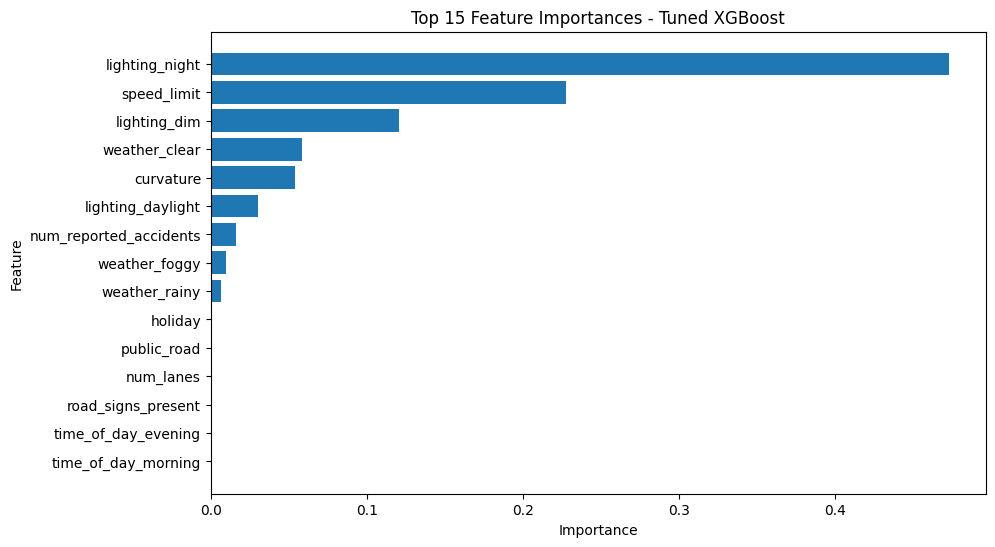

In [40]:
# Extract fitted model from pipeline
best_model = best_xgb.named_steps["model"]

# Get feature names after preprocessing
encoded_feature_names = (
    best_xgb.named_steps["preprocessor"]
    .transformers_[1][1]  # categorical transformer
    .named_steps["encoder"]
    .get_feature_names_out(categorical_features)
)

# Combine numeric + encoded categorical + boolean features
feature_names = np.concatenate([
    numeric_features,
    encoded_feature_names,
    boolean_features
])

# Get importance scores
importances = best_model.feature_importances_

# Build importance dataframe
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
plt.barh(fi_df["Feature"][:15][::-1], fi_df["Importance"][:15][::-1])
plt.title("Top 15 Feature Importances - Tuned XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

* Visibility (lighting conditions) dominates the model — far more than weather or time of day.
* Speed limits are the second most influential lever — a key policy variable for intervention.
* Curvature confirms geometric risk, aligning with traffic safety literature.
* The model may not be benefiting much from categorical dummies like holiday or school_season; they’re near-zero — could prune or combine them later.
* A SHAP summary plot would make this interpretation more robust and show directionality (e.g., how night lighting increases risk, not just that it’s predictive).

### SHAP Analysis - Understanding Feature Influence

After tuning our best model (XGBoost), we perform SHAP (SHapley Additive exPlanations) analysis to interpret how each feature influences accident risk predictions. Unlike standard feature importance, SHAP values provide directionality — showing whether a feature increases or decreases predicted risk for specific observations.

In [ ]:
import shap
# Extract preprocessor and model
preprocessor = best_xgb.named_steps["preprocessor"]
xgb_model = best_xgb.named_steps["model"]

# Transform X_test into encoded numeric form
X_test_transformed = preprocessor.transform(X_test)

# Get feature names after preprocessing (if available)
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrame for SHAP
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Compute SHAP values
# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_transformed_df)

# Global feature importance
shap.summary_plot(shap_values, X_test_transformed_df, plot_type="bar")

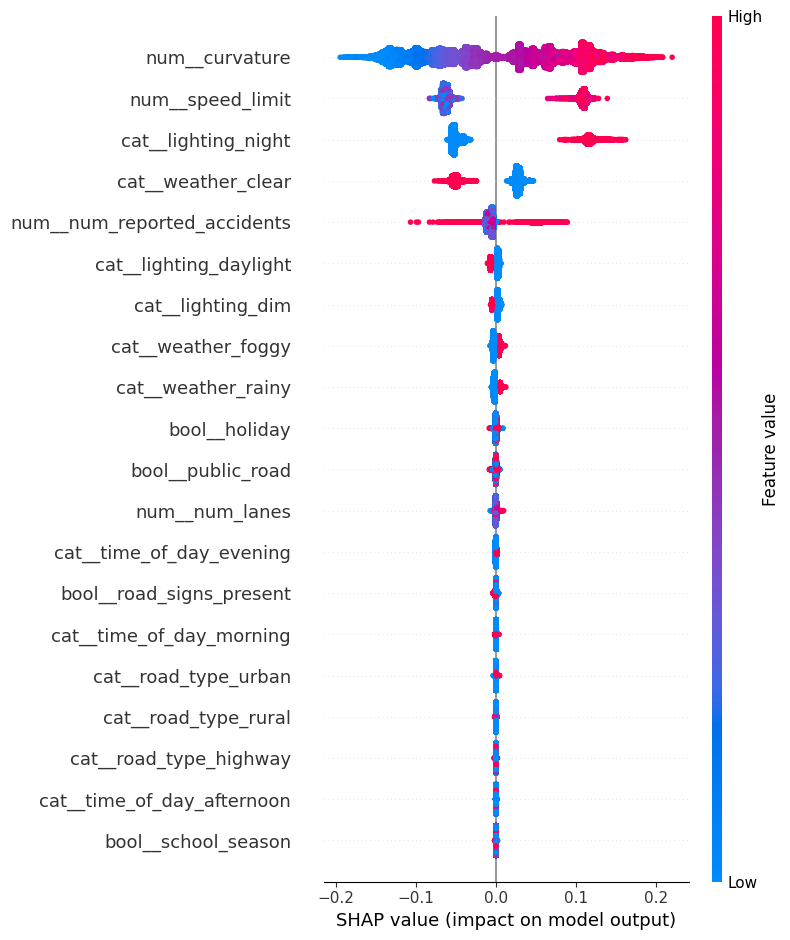

In [42]:
# Detailed influence by value direction
shap.summary_plot(shap_values, X_test_transformed_df)

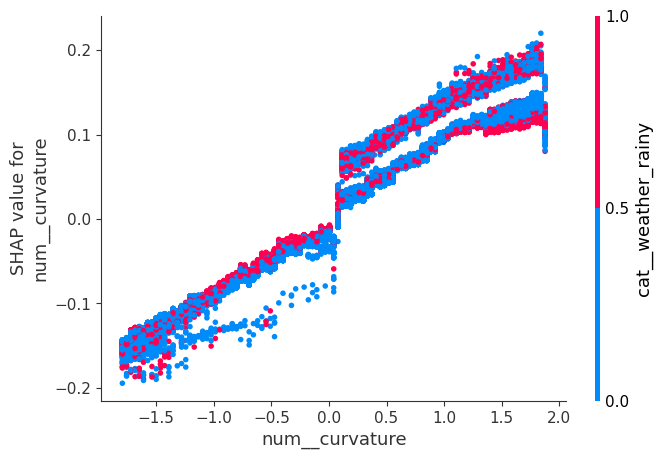

In [43]:
# Example interaction: curvature vs. weather_rainy
shap.dependence_plot("num__curvature", shap_values, X_test_transformed_df, interaction_index="cat__weather_rainy")

SHAP Pattern: Strong positive SHAP values at higher curvature levels.

Meaning: As roads become more curved or winding, predicted accident risk increases sharply — likely due to limited visibility and reduced control.

*Curvature × Weather:*

When weather is foggy or rainy, the SHAP contribution of curvature grows — the model implicitly captures that a curved road in bad weather is riskier than either condition alone.

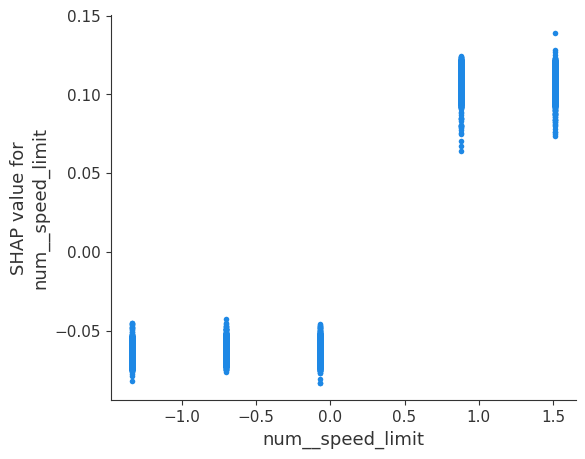

In [44]:
# Example interaction: curvature vs. weather_rainy
shap.dependence_plot("num__speed_limit", shap_values, X_test_transformed_df, interaction_index=None)

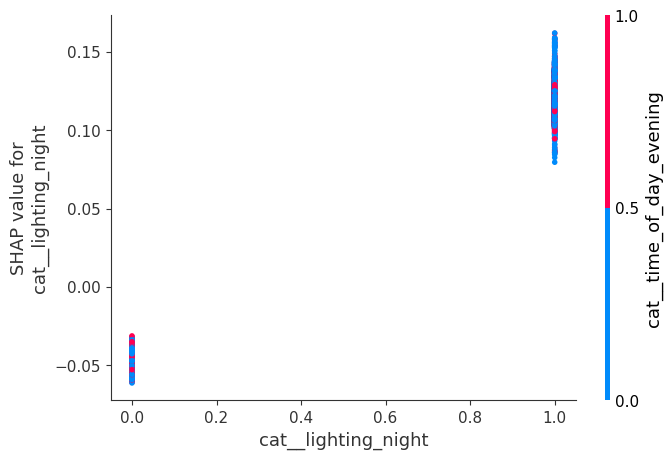

In [45]:
# Example interaction: curvature vs. weather_rainy
shap.dependence_plot("cat__lighting_night", shap_values, X_test_transformed_df, interaction_index='cat__time_of_day_evening')

The model’s behavior is physically and intuitively consistent:

“Accidents are most likely when visibility is reduced (night/fog), road geometry is demanding (curvature), and speed potential is high.”

### Model Selection

We compared multiple models (linear, tree-based, and gradient boosting) on cross-validation and test performance to identify the most reliable predictor of accident risk.

| Model             | CV RMSE | Test RMSE | R²     | Notes                                     |
| ----------------- | ------- | --------- | ------ | ----------------------------------------- |
| XGBoost (tuned)   | 0.0560  | 0.0562    | 0.8855 | Best balance of performance and stability |
| CatBoost          | 0.0563  | 0.0563    | 0.8854 | Competitive, less hyperparameter tuning   |
| LightGBM          | 0.0562  | 0.0563    | 0.8850 | Strong, slightly less interpretable       |
| Random Forest     | 0.0593  | 0.0594    | 0.8721 | Slight overfit                            |
| Linear Regression | 0.0735  | 0.0735    | 0.8041 | Baseline                                  |
| SVR               | 0.0740  | 0.0740    | 0.8014 | Underperforms                             |


*Selection Criteria*:

We selected XGBoost (tuned) as the final model because it has the lowest RMSE on cross-validation and test sets, high R², and shows consistent, interpretable feature importance patterns. CatBoost is a close second and could be used interchangeably for ensemble experiments.

### Final Predictions

In [46]:
# type(best_model)

In [48]:
# Apply the preprocessing pipeline to X_test
X_test_processed = preprocessor.transform(test.drop(columns=[id_col]))

# Predict using the tuned XGBoost model
final_preds = best_model.predict(X_test_processed)

# Optional: Save predictions for submission / portfolio display
submission = pd.DataFrame({
    "id": test[id_col],
    "accident_risk": final_preds
})
submission.to_csv("submission.csv", index=False)
print('Submissions file created successfully')

Submissions file created successfully


In [50]:
# Sanity check
pd.read_csv('submission.csv').shape

(172585, 2)

The final model provides robust accident risk predictions for all test observations. These predictions reflect the combined influence of road geometry, lighting, speed, and weather conditions, and are ready for downstream analysis, visualization, or deployment.

## Insights Summary/Recommendations

Lighting conditions and speed limits emerged as the strongest determinants of accident risk. Accidents are far more likely under poor lighting or higher speed limits. Interestingly, road curvature interacts with weather — curved roads under fog or rain contribute disproportionately to risk. These findings suggest targeted interventions like improved night lighting and stricter speed enforcement in curved road sections.

## Future Work

* Incorporate real-time weather and traffic data streams
* Test temporal generalization using data from other years
* Build a web dashboard to visualize accident risk zones interactively

## Conclusion

This project demonstrates a full end-to-end accident risk prediction workflow — from exploratory analysis and feature engineering to model tuning and interpretability. Beyond prediction, it highlights actionable insights that could inform smarter, data-driven road safety strategies.